# Idea del Proyecto: Predicción del Éxito de una Canción
Paso 1: Recopilación de Datos

a) Datos de Spotify API:

Utiliza la API de Spotify para recopilar datos sobre las características de las canciones. Puedes obtener información sobre el tempo, la energía, la bailabilidad, la popularidad, etc.

b) Scraping Web:

Realiza scraping en una página como Billboard para obtener datos sobre el rendimiento de las canciones en las listas de éxitos. Esto te dará una idea de qué canciones fueron exitosas y cuáles no. Puedes buscar la posición en las listas de las canciones, la cantidad de semanas que estuvieron en las listas, etc.


Paso 2: Procesamiento y Análisis de Datos
Combina los datos de la API de Spotify con los datos de scraping para crear un conjunto de datos completo.
Realiza un análisis exploratorio de datos para comprender mejor las características de las canciones exitosas.
Limpia y prepara los datos para el modelado.

Paso 3: Modelado y Predicción
a) Algoritmos de Clasificación o Predicción:

Utiliza algoritmos de clasificación o regresión para predecir el éxito de una canción.
Algunos algoritmos que podrías probar incluyen:
Regresión Logística
Árboles de Decisión
Bosques Aleatorios
Gradient Boosting
Redes Neuronales
b) Evaluación del Modelo:

Divide tus datos en conjuntos de entrenamiento y prueba.
Entrena varios modelos y evalúa su rendimiento utilizando métricas como precisión, exhaustividad, F1-score, etc.



# Implementación:
1. Recopilación de datos:
Utiliza la API de Spotify para recopilar datos sobre las características de las canciones. Puedes usar la biblioteca spotipy para Python.
Realiza scraping en la página de Billboard para obtener datos sobre el rendimiento de las canciones en las listas de éxitos.

In [103]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Credenciales de la API de Spotify
client_id = '3fc2f3c071d8480b96aa379242a07502'
client_secret = 'b838c1a11677441eb4a633bda27b9873'


# Inicialización de la API de Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [3]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Dividir los datos en conjunto de entrenamiento y prueba
# X = df_combined[['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#                  'instrumentalness', 'liveness', 'valence', 'tempo']]
# y = df_combined['billboard_rank'].apply(lambda x: 1 if x <= 10 else 0)  # Éxito: Posición en el top 10 de Billboard

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Inicializar y entrenar el modelo de Bosques Aleatorios
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Predicción
# y_pred = rf_model.predict(X_test)

# # Evaluación del modelo
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


In [104]:
def get_artist_info(artist_name):
    """
    This function takes an artist name as input and returns a dictionary containing the artist's ID and genre (if available).

    Args:
        artist_name (str): The name of the artist to search for.

    Returns:
        dict: A dictionary containing the artist's ID and genre (or None if not found).
    """

    search_results = sp.search(q=artist_name, type='artist')
    artists = search_results['artists']['items']

    if artists:
        artist_info = artists[0]  
        artist_id = artist_info['id']
        genres = artist_info.get('genres', [])  
        albums_results = sp.artist_albums(artist_id)
        album_ids = [album['id'] for album in albums_results['items']]

        album_tracks = {}
        total_tracks = []  

        # Loop through each album ID
        for album_id in album_ids:
            # Get album tracks (limit to 50 tracks per request)
            tracks_results = sp.album_tracks(album_id, limit=50)
            tracks = tracks_results['items']

            while tracks_results['next']:
                tracks_results = sp.next(tracks_results)
                tracks.extend(tracks_results['items'])
                
            album_tracks[album_id] = [track['id'] for track in tracks]
            total_tracks.extend(album_tracks[album_id])

        return {
            'artist_id': artist_id,
            'genres': genres,
            'album_ids': album_ids,
            'album_tracks': album_tracks,
            'total_tracks': total_tracks
        }


In [105]:
# Obtener datos de una canción (ejemplo)
def get_track_features(track_id):
    track_info = sp.track(track_id)
    features = sp.audio_features(track_id)[0]
   
    return {
        'track_id': track_info['id'],
        'track_name': track_info['name'],
        'artist_name': track_info['artists'][0]['name'],
        'popularity': track_info['popularity'],
        'danceability': features['danceability'],
        'energy': features['energy'],
        'key': features['key'],
        'loudness': features['loudness'],
        'mode': features['mode'],
        'speechiness': features['speechiness'],
        'acousticness': features['acousticness'],
        'instrumentalness': features['instrumentalness'],
        'liveness': features['liveness'],
        'valence': features['valence'],
        'tempo': features['tempo'],
        'duration_seg' : features['duration_ms']/1000
    }


In [118]:
# def create_dataframe(artist_data):
#     tracks_data = [get_track_features(track_id) for track_id in artist_data['total_tracks']] 
#     df = pd.DataFrame(tracks_data)
#     df['genre'] = None
#     df['genre'].fillna(artist_data['genres'][0], inplace=True)
#     print(df)
#     return df

def create_dataframe(artist_names):
    """
    This function takes a list of artist names and returns a DataFrame containing combined track features for all artists.

    Args:
        artist_names (list): A list containing names of artists to search for.

    Returns:
        DataFrame: A DataFrame containing combined track features.
    """

    # Initialize an empty DataFrame to store combined results
    df = pd.DataFrame()

    # Loop through each artist name
    for artist_name in artist_names:
        artist_data = get_artist_info(artist_name)  # Get artist information

        # Extract track IDs and features
        tracks_data = [get_track_features(track_id) for track_id in artist_data['total_tracks']]

        # Create a temporary DataFrame for this artist's tracks
        artist_df = pd.DataFrame(tracks_data)

        # Add a 'genre' column and fill with the first genre (assuming single genre)
        artist_df['genre'] = None
        artist_df['genre'].fillna(artist_data['genres'][0], inplace=True)  # Assuming first artist's genre

        # Concatenate the artist's DataFrame to the combined DataFrame
        df = pd.concat([df, artist_df], ignore_index=True)  # Avoid duplicate indices

        #El df tenia algunos artista infiltrados, por lo que se deben eliminar
        # unwanted_artist = df[~df["artist_name"].isin(artist_names)].index
        # df.drop(unwanted_artist, inplace=True)

    return df

# Call the function after retrieving artist 
#"Trueno","Airbag","Duki","Babasónicos",
artist_names = ["Trueno","Airbag","Duki"]
# artist_data = get_artist_info(artist_names)

df_spotify = create_dataframe(artist_names)


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=3dD1H5ick5Txfngx7hje7X:
 Max Retries, reason: too many 429 error responses

In [110]:
print(get_artist_info("La Joaqui"))

{'artist_id': '60XHOAhvEBiV6BGBOv8ClM', 'genres': ['argentine hip hop', 'rap latina'], 'album_ids': ['2Zb3Aq1Z1eUkAEIvmaZknJ', '2gHI9iIrqf2M1ZGWKjXWEy', '1cxQmxya83OtztHKYKG8fn', '0Fp8YIrA3udbfxtjtC6PJd', '7p4UU8OpGtFiHe0h9LfEbj', '2wljB7jT9Wkfp2o7cKz2Fb', '1ZPwG0m0QpSpsPKcmqAJdj', '137FrrdmnOdVAOm013Kg4o', '4uwtiHu1B2ESnqNzlFXGNO', '3FthtqxiqcpsNiypZhUtRY', '7gdlWroAiyBT9N70ZxnXG2', '1VM5SbtCPTxzTqvK03sqUy', '4dlrWntcibuDtUW2jOE6lj', '3JFn85xyQoSqwaMaVpYknB', '47LBnwJDhEr9orf488dmnX', '6aksfRpRyzjh0Hdz2Mp3am', '50fDCiIhdGoiJLSYXdLbt9', '3kSWysuWqvXUbjkZoCkmPZ', '2RGsU2rnNGORVw1C4QLabe', '3iggaiQChBAIIfQP8ZH2bR'], 'album_tracks': {'2Zb3Aq1Z1eUkAEIvmaZknJ': ['2ka5Ij6Nasvr5krBY93TgM', '1dPeTvaCjewkzzHKszESGW', '2bvd7zLOfkyvfyXCx38O4G', '5iA4WKK8PGFiQgiEJc7zuE', '2cYpGglgQ2y7ySE3aIgVo2', '4KWGRLmZW41t4KlcD5xW2X', '7El9pmDQt976FEnjjMasHv', '3EH8v2esTPHPBF596E3cyG', '5PEXn2NBkFB41EIVXFqGkz', '4ZL0fM4CVzMuFAmGCVT2LE', '31oJF37hgotrhpPQeajmuu', '7awNIrH7RwxWApdLouxSEv'], '2gHI9iIrqf2M1ZGWKjXW

In [85]:
print(len(df_spotify))

175


In [78]:
print(df_spotify[df_spotify["artist_name"] == "Babasonicos"])

Empty DataFrame
Columns: [track_id, track_name, artist_name, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_seg, genre]
Index: []


In [111]:
print(df_spotify['genre'].value_counts()['argentine rock'])
print(df_spotify['genre'].value_counts()['argentine hip hop'])

175


KeyError: 'argentine hip hop'

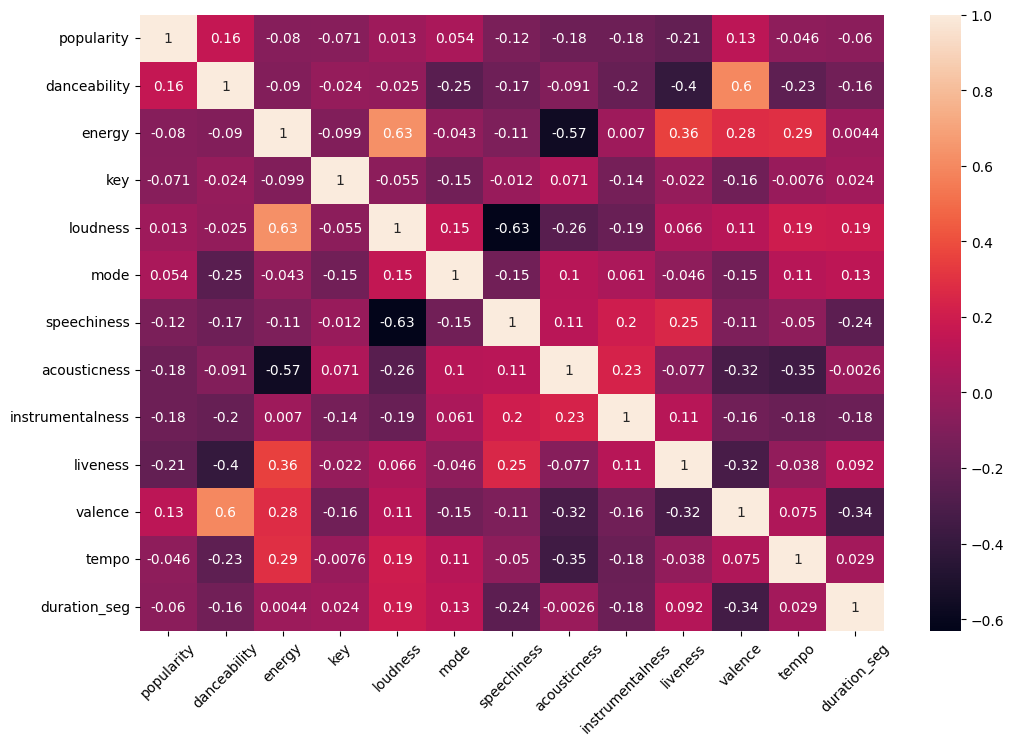

In [112]:
columna_a_eliminar = ['track_id','track_name','artist_name','genre']
df_heatmap = df_spotify.drop(columna_a_eliminar
                             ,axis=1)
correlation = df_heatmap.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.show()

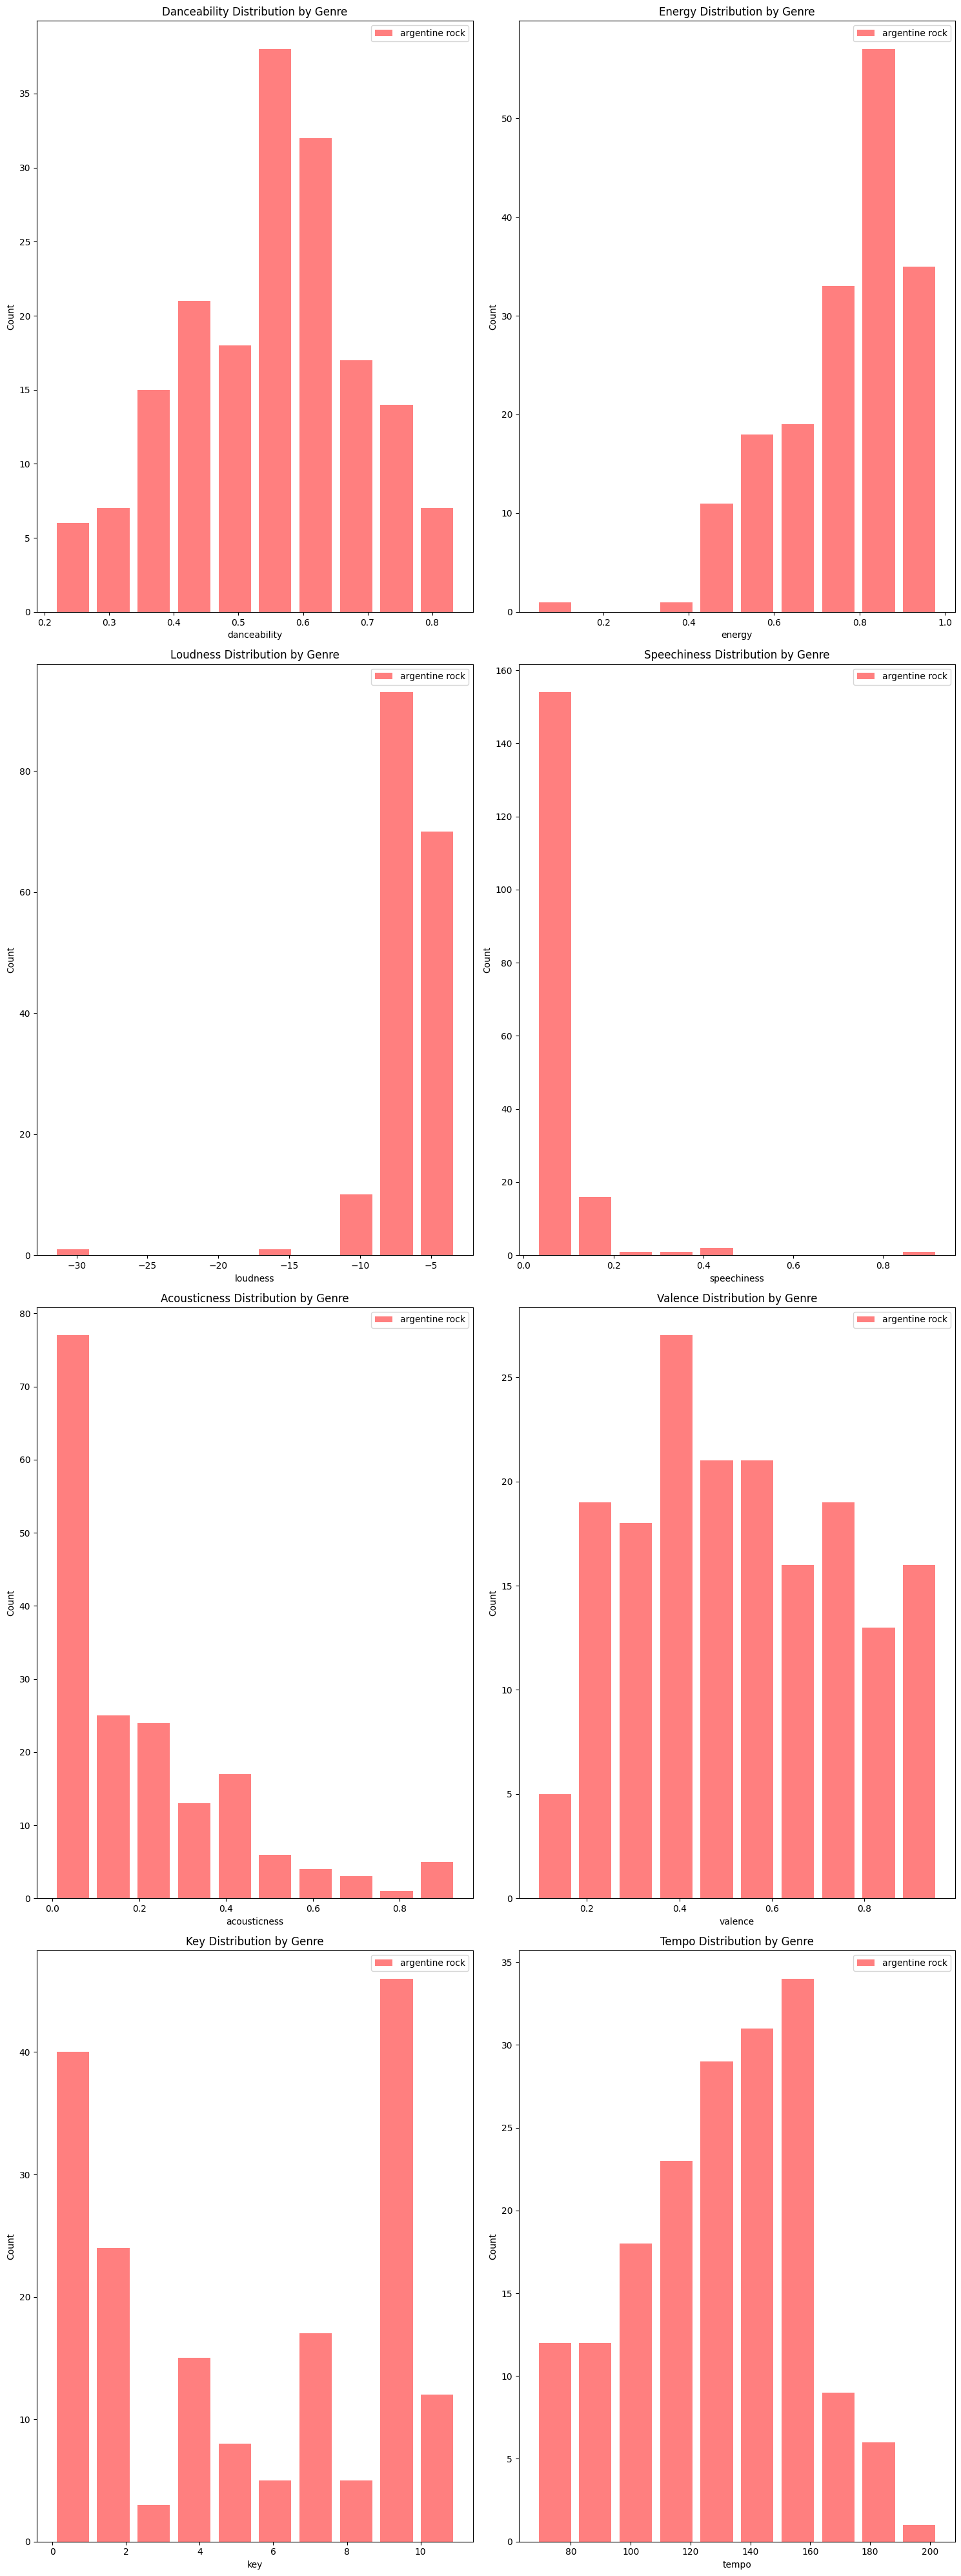

In [119]:
def plot_histogramas_por_feature(df, features, genre_colors=None):
    """
    Crea un conjunto de histogramas para varias características (features) de las canciones de un DataFrame,
    filtrando por cada género presente en el DataFrame.

    Parámetros:
        - df: DataFrame de Pandas que contiene los datos de las canciones.
        - features: Lista de características (columnas) para las que se crearán los histogramas.
        - genre_colors: Un diccionario que asigna colores a los géneros. Si no se proporciona,
          se utilizarán colores predeterminados.

    Retorna:
        - None
    """
    if genre_colors is None:
        genre_colors = {'argentine hip hop': 'blue', 'argentine rock': 'red'}  # Colores predeterminados

    num_features = len(features)
    num_rows = (num_features + 1) // 2  # Calcular el número de filas para la matriz de subgráficos
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 10*num_rows))  # Crear una matriz de subgráficos

    for idx, feature in enumerate(features):
        row_idx = idx // 2  # Calcular el índice de fila en la matriz de subgráficos
        col_idx = idx % 2   # Calcular el índice de columna en la matriz de subgráficos
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]  # Seleccionar el subgráfico adecuado

        # Iterar sobre cada género presente en el DataFrame
        for genre in df['genre'].unique():
            # Filtrar los datos para el género actual
            genre_data = df[df['genre'] == genre][feature]

            # Crear el histograma para el género actual
            ax.hist(genre_data, label=genre, color=genre_colors.get(genre, 'gray'), alpha=0.5, rwidth=0.8)  # Ajustar rwidth para el ancho de las barras

        # Agregar leyenda, etiquetas y título al subgráfico
        ax.legend()
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.set_title(f'{feature.capitalize()} Distribution by Genre')

    # Ajustar el espacio entre subgráficos y mostrar la figura
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
# Suponiendo que tienes un DataFrame df_spotify con tus datos
# Suponiendo que genre_colors es un diccionario de colores para géneros personalizados
features = ['danceability','energy','loudness','speechiness','acousticness', 'valence', 'key', 'tempo']  # Lista de características a visualizar

# Llamar a la función para plotear histogramas para las características especificadas
plot_histogramas_por_feature(df_spotify, features)


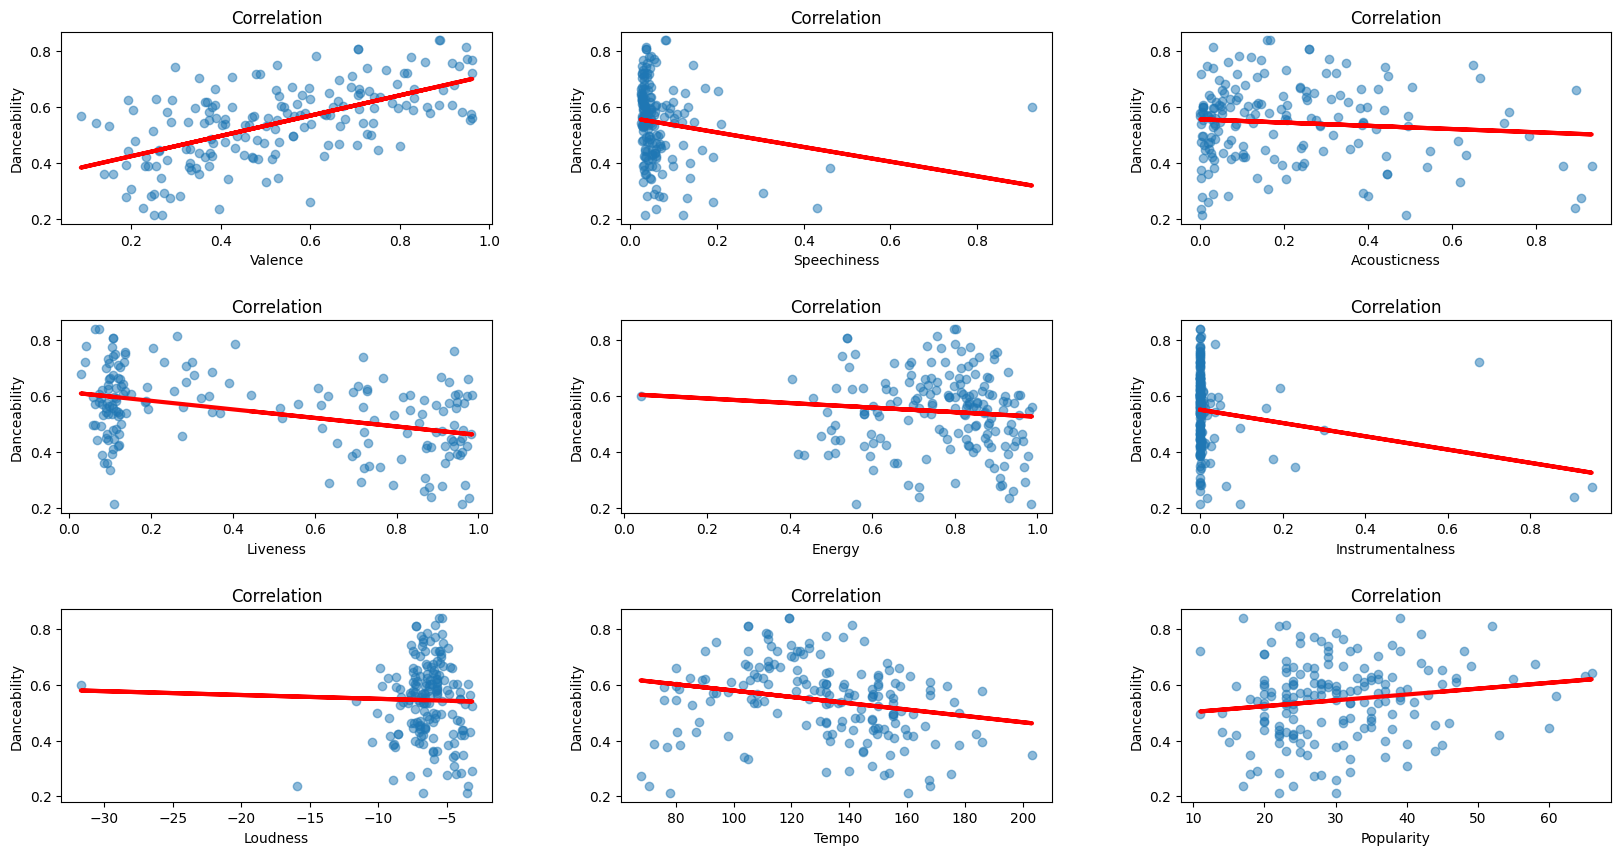

In [114]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot_feature(ax, feature_name, X, y, x_label):
    regr = LinearRegression()
    regr.fit(X, y)

    ax.scatter(X, y, alpha=0.5, label=f'{feature_name} vs. Danceability')
    ax.plot(X, regr.predict(X), color="red", linewidth=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Danceability")
    ax.set_title("Correlation")

# Create a single figure for all the subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

# List of features and their corresponding column names
features = ["Valence", "Speechiness", "Acousticness", "Liveness", "Energy", "Instrumentalness", "Loudness", "Tempo","Popularity"]
columns = ["valence", "speechiness", "acousticness", "liveness", "energy", "instrumentalness", "loudness", "tempo","popularity"]

for i, feature_name in enumerate(features):
    row, col = divmod(i, 3)
    plot_feature(
        axes[row, col],
        feature_name,
        df_spotify[[columns[i]]].values,
        df_spotify["danceability"].values,
        feature_name
    )
plt.show()

# Logistic regression

In [115]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [117]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a 

#Genero. 0 = Argentine rock ; 1 = argentine hip hop 
df_spotify['rockhiphop'] = 0 # empezamos con una columna llena de 0.
indice =  df_spotify['genre'] == 'argentine hip hop'  
df_spotify.loc[indice, 'rockhiphop'] = 1 

df_spotify['rockhiphop'].value_counts()


# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['rockhiphop'] # Nuestra etiqueta sigue siende la misma de antes
print(X.shape) 

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

(175, 12)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'argentine rock'

In [116]:
df_spotify.head()

,track_id,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seg,genre
0,3V8rFQhTS52MoHsfdvUVY4,Un Hombre Más (Sinfónico),Ciro y los Persas,30,0.212,0.560,0,-6.709,1,0.0340,0.4910,0.000189,0.1090,0.268,77.984,325.337,argentine rock
1,0AJmZk923I2EID3yESTwYS,Ando Ganas (Llora Llora) (Sinfónico),Ciro y los Persas,28,0.563,0.601,0,-7.614,1,0.0276,0.2640,0.000001,0.0976,0.390,132.923,329.586,argentine rock
2,0YqbfdstF6TGvCIazCjt4G,Carrousel (Sinfónico),Ciro y los Persas,32,0.536,0.743,7,-6.538,1,0.0410,0.3860,0.000000,0.1230,0.464,106.948,306.847,argentine rock
3,3FDP19bA99geyUNE7qPwKb,Dientes de Cordero (Sinfónico),Ciro y los Persas,32,0.481,0.763,9,-5.835,0,0.0295,0.0739,0.000000,0.1130,0.480,142.009,296.346,argentine rock
4,4pjfIpxKCEX6mJvYELNxs5,Ruidos (Sinfónico),Ciro y los Persas,30,0.544,0.491,9,-7.065,0,0.0242,0.7230,0.036100,0.1180,0.121,76.022,340.857,argentine rock


In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_train[2],4)))
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_test[2],4)))

Para TRAIN set:
El score del modelo es de: 1.0
Matriz de confusion del modelo es:
[[99  0]
 [ 0 72]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 1.0
BA del modelo es de: 1.0


Para TEST set:
El score del modelo es de: 0.8919
Matriz de confusion del modelo es:
[[38  3]
 [ 5 28]]
Sensibilidad del modelo es de: 0.9032
Especificidad del modelo es de: 0.8837
BA del modelo es de: 0.8935


# Clustering 

 

In [13]:
# importamos las librerías usuales de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    # K-means
from sklearn.cluster import AgglomerativeClustering   # Clustering jerárquico

# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador


In [30]:
df_spotify.head()

,track_id,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seg,genre
0,3dD1H5ick5Txfngx7hje7X,HOOP HOOP,Trueno,51,0.482,0.894,D,-3.595,menor,0.1100,0.400,0.0,0.7290,0.392,91.303,157.325,argentine hip hop
1,1iEv1uCSDTN7YotFX4iHB9,FUCK EL POLICE,Trueno,54,0.594,0.786,A#,-4.327,mayor,0.3690,0.313,0.0,0.1000,0.113,90.837,157.554,argentine hip hop
2,3lkiTKxSDxOqZkQnf9FUEo,ARGENTINA,Trueno,58,0.575,0.670,E,-5.656,mayor,0.3750,0.824,0.0,0.2510,0.362,174.211,233.214,argentine hip hop
3,73zQG7t3tZDyePEflVSqJJ,TIERRA ZANTA,Trueno,59,0.565,0.807,C#,-5.413,mayor,0.2740,0.547,0.0,0.4210,0.310,104.777,237.658,argentine hip hop
4,6egwHn0qyQH7HCFu4APhmk,UN PASO,Trueno,0,0.778,0.853,D,-3.455,menor,0.0748,0.249,0.0,0.0932,0.533,92.959,192.143,argentine hip hop


In [43]:
# Creación del modelo de PCA con 100 componentes
pca = PCA(n_components = 10)
#Vamos a determinar las columnas que tengan algun peso significativo para este modelo
columna_a_eliminar = ['track_id','track_name','artist_name','genre','popularity','key','mode']
df_gener,targets = df_spotify.drop(columna_a_eliminar
                             ,axis=1),df_spotify['genre']
# Ajuste y transformación de los datos
pca.fit(df_gener)
X_pca = pca.transform(df_gener)
X_pca.shape

(158, 10)

Ploteamos el dataset en el espacio de las primeras dos componentes principales

Text(0, 0.5, 'Segunda componente principal')

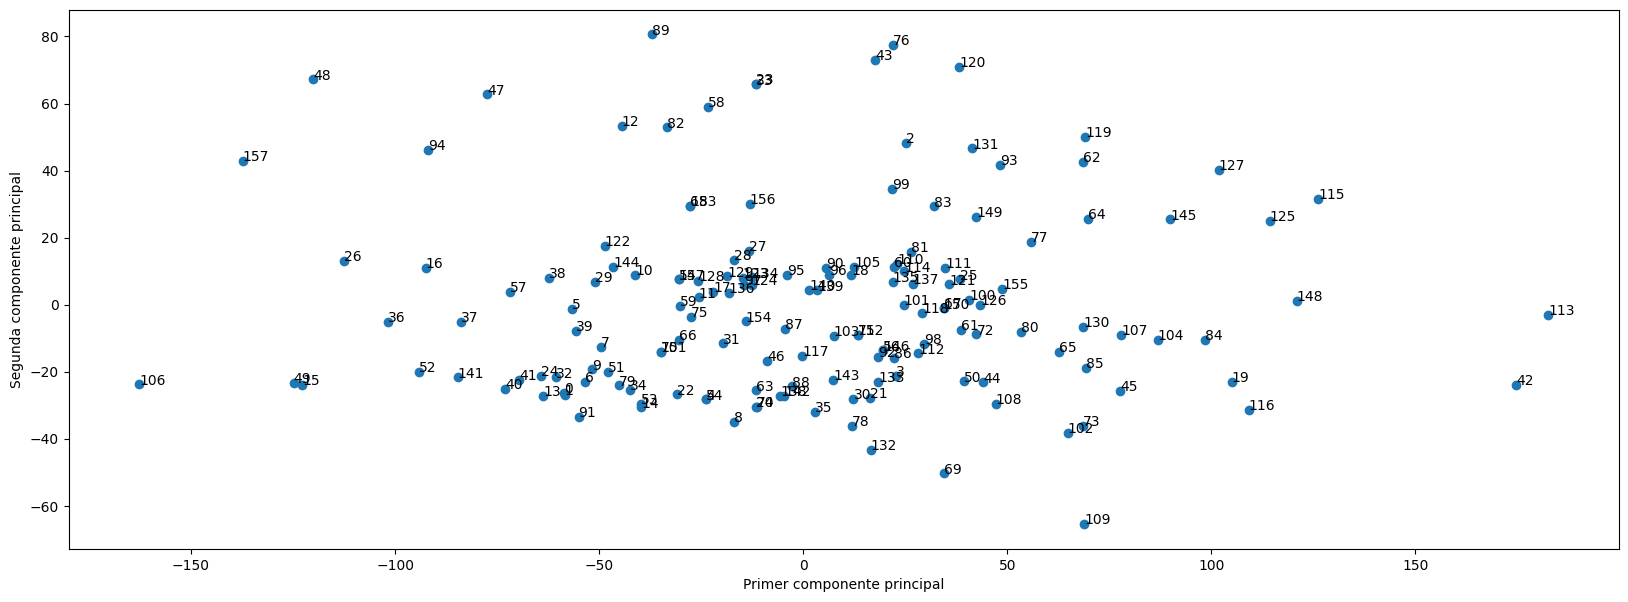

In [34]:
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Por cada dato escribimos a qué instancia corresponde
for i in range(df_gener.shape[0]):
  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Ahora sí aplicamos el método de clusterización K-Means para agrupar las fotos en base a sus componentes principales. Como sabemos que el dataset consta de 2 generos diferentes utilizamos esta información para pedirle al algoritmo que encuentre k=2 clusters con la esperanza que podamos agrupar las cansiones en ellos.

In [35]:
# Creación del modelo KMeans con k = 40
kmeans = KMeans(n_clusters=2)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

KMeans(n_clusters=2)

Para acceder a las etiquetas que le asignó el modelo a cada sample usamos 'kmeans.labels_'

In [36]:
# Nos fijamos las etiquetas asignadas a las primeras 10 muestras y los counts que recibió cada una
np.unique(kmeans.labels_[:10], return_counts=True)

(array([0, 1]), array([2, 8], dtype=int64))

Veamos qué es lo que está pasando. Vamos a plotear el dataset en el espacio de las primeras dos componentes principales pero además vamos a asignarle un color a cada sample que corresponde a la etiqueta asignada por el modelo. También vamos a graficar con una "X" el centroid de cada cluster.

In [37]:
# Guardo las posiciones de los centroids
centroids = kmeans.cluster_centers_

# Printeo las dimensiones de las posiciones
print("Shape de los centroids:",centroids.shape)
# Printeo las posiciones de las primeras 5 muestras en sus primeras dos componentes principales
print(centroids[:5,[0,1]])

Shape de los centroids: (2, 10)
[[ 45.52391024   0.40876601]
 [-44.38581248  -0.39854685]]


Text(0, 0.5, 'Segunda componente principal')

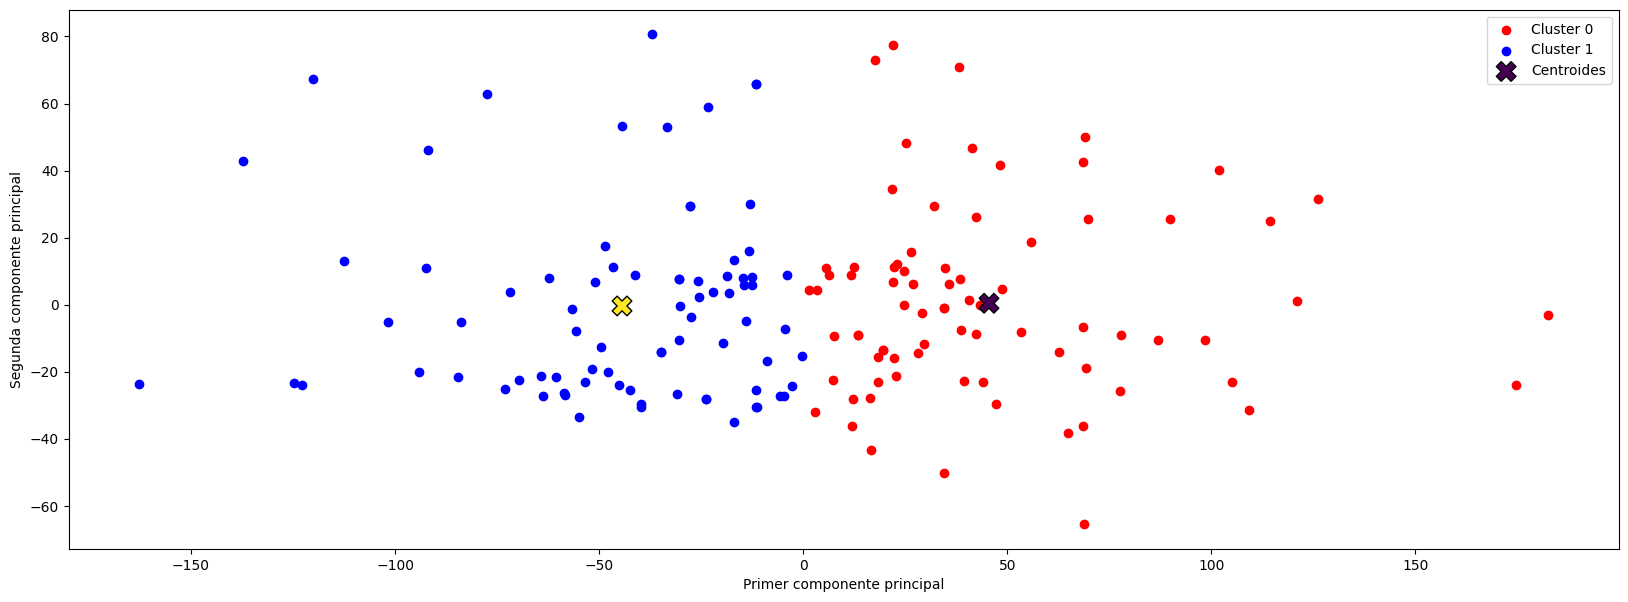

In [38]:
# Este bloque es similar al anterior pero agregando color a cada muestra en el scatter plot según la etiqueta asignada

fig, ax = plt.subplots(figsize=(20, 7))

# Crear un diccionario de colores para asignar colores específicos a cada etiqueta
colors = {0: 'red', 1: 'blue'}

# Hacer un scatter plot de cada uno de los datos con colores específicos para cada etiqueta
for label in np.unique(kmeans.labels_):
    ax.scatter(X_pca[kmeans.labels_ == label, 0], X_pca[kmeans.labels_ == label, 1],
               c=colors[label], label=f'Cluster {label}')

# Hacer un scatter plot de los centroides con el mismo color que las etiquetas
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black', label='Centroides')

# Agregar la leyenda
ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')


In [39]:
# Mostrar el resultado final
# labels = kmeans.labels_
# Suponiendo que ya tienes un DataFrame df y las etiquetas de cluster kmeans.labels_

# Agregar una columna al DataFrame con las etiquetas de cluster
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets

df_gener.head(50)

# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)


cluster             0   1
genre                    
argentine hip hop  13  42
argentine rock     65  38


#### 1 [Método del codo](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)

Se hace un grafico de la función objetivo en función de la elección de k y se elige el k correspondiente al punto donde agregar un cluster más no baja significativamente el valor que queremos minimzar. Esto se puede detectar a ojo o utilizando algún paquete de python como ['kneed'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf)

In [40]:
from kneed import KneeLocator # importamos el paquete para detectar el codo

In [44]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 40):
  print(k)
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(df_gener)
  sse.append(kkmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Vamos a graficar SEE en función del número de clusters k

Text(0, 0.5, 'SSE')

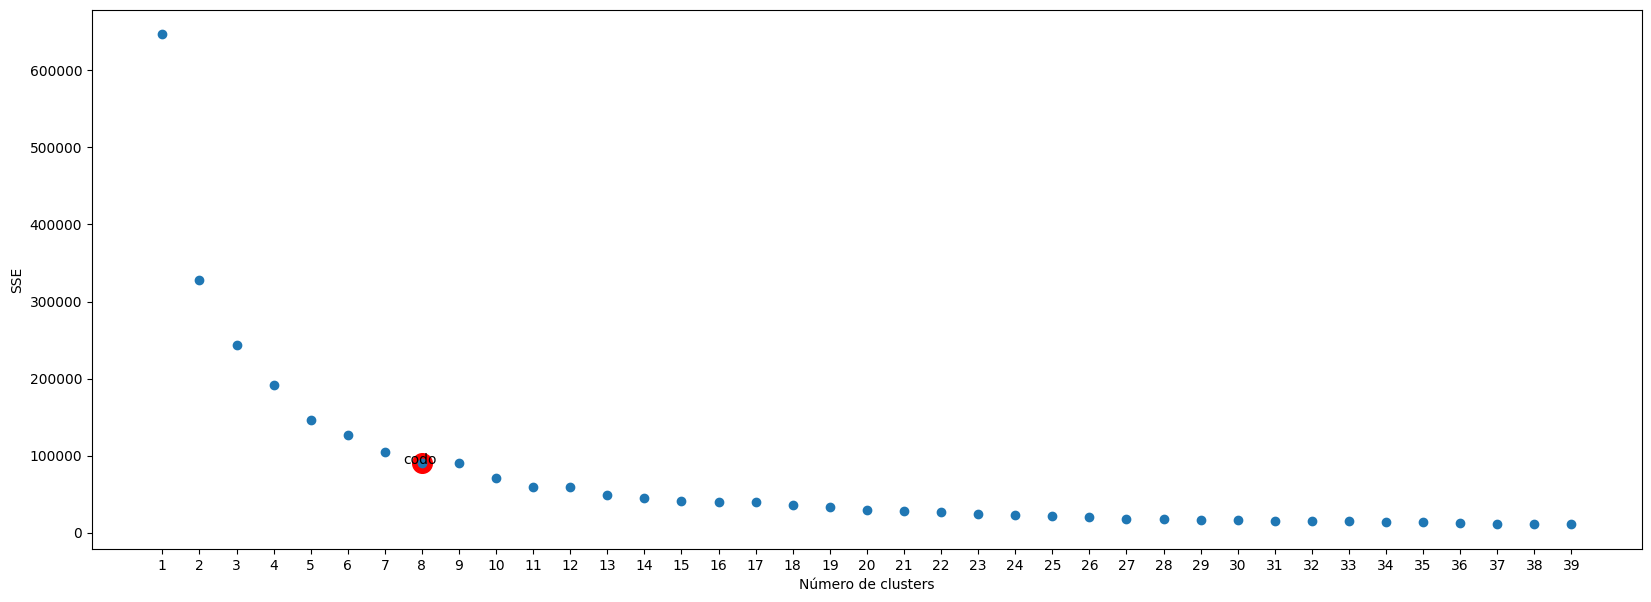

In [45]:
fig, ax = plt.subplots(figsize = (20, 7))

# esta dos lineas las agrego para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(8, sse[7], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(7.5, sse[7]-1000, s="codo")       # agregamos un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SSEvsK
ax.scatter(range(1, 40), sse)
ax.set_xticks(range(1, 40))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("SSE")

In [46]:
kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

El codo está en k = 7


Veamos entonces cómo se ve el modelo con k=9 para el dataset

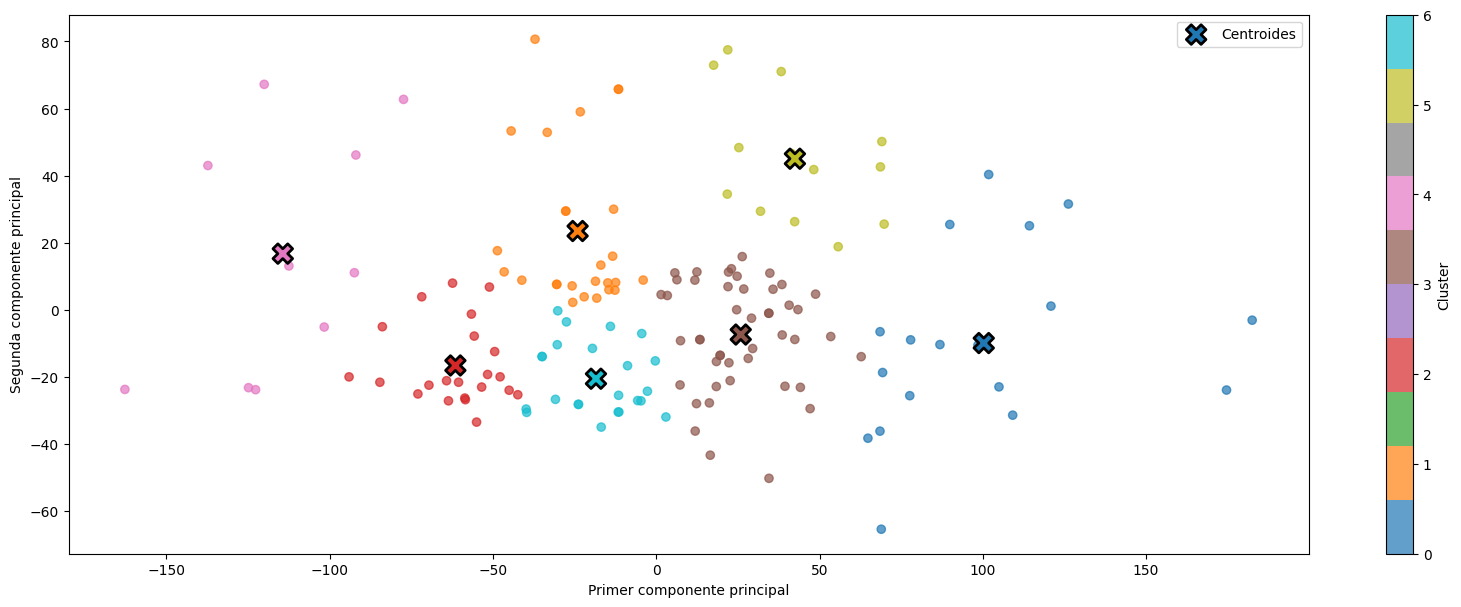

In [47]:
# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()


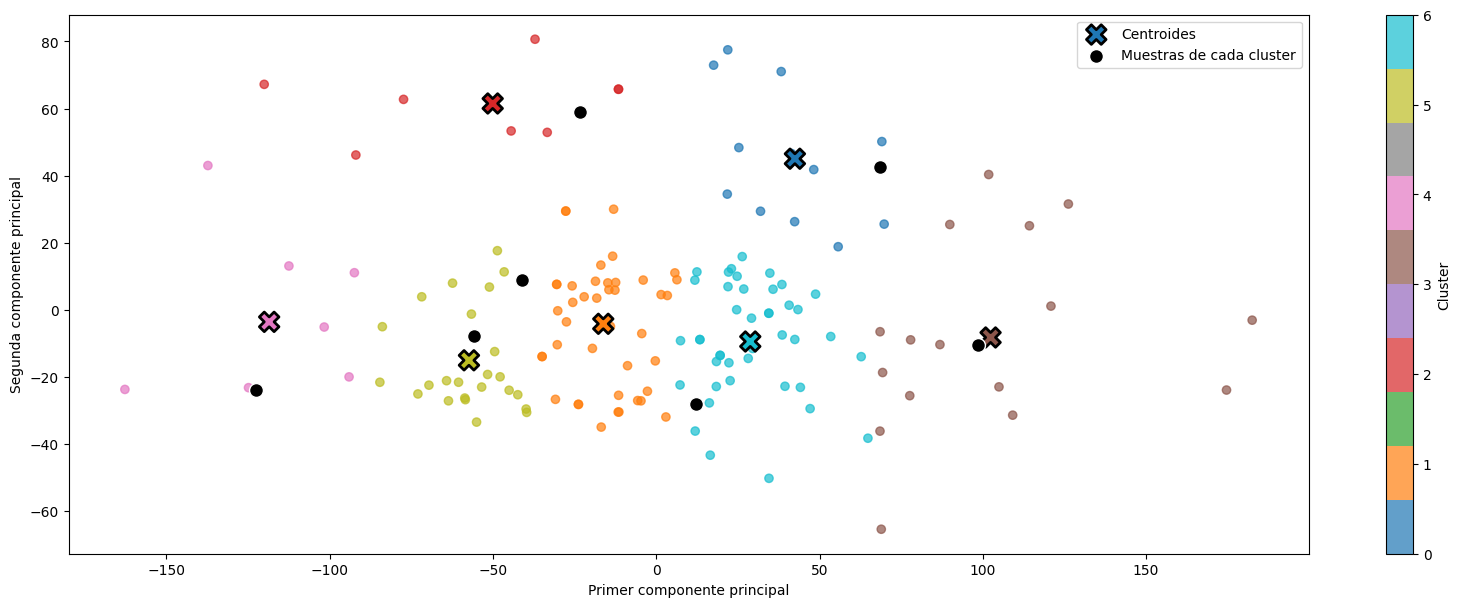

Muestras de cada cluster:
Cluster 0: [ 6.86640592e+01  4.25885669e+01  9.44037351e-01 -1.41314475e-01
  9.62474969e-02  7.60976092e-02 -7.43142755e-02 -7.35206606e-03
 -1.09746687e-02 -3.72734280e-02]
Cluster 1: [-41.16361454   8.78826049   1.67873286   0.07588895   0.14081144
  -0.15436917  -0.24786039  -0.05394868   0.12336691  -0.07245281]
Cluster 2: [-2.32571704e+01  5.90166975e+01  2.31434457e+00 -3.00993349e-01
 -2.12449956e-01 -1.85147691e-01  7.65378075e-02  1.03413133e-01
 -8.69682176e-02 -6.10815217e-03]
Cluster 3: [ 9.85188525e+01 -1.05898062e+01 -1.70408873e-01 -9.95841058e-02
 -1.16291415e-01  2.22496922e-01  3.50403670e-02 -2.57019134e-02
  6.45584296e-02 -1.04299828e-02]
Cluster 4: [-1.22713201e+02 -2.38737658e+01  2.36130725e+00 -1.53090520e-01
  5.67659675e-01  4.30618788e-01 -2.71236124e-01 -5.31991308e-04
 -1.29570850e-01  1.72458664e-01]
Cluster 5: [-5.57425986e+01 -7.88865329e+00 -1.46662847e+00  2.72146040e-01
 -2.55589131e-01  1.74614232e-02 -3.29733713e-02 -6.51

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supongo que X_pca ya está definido y contiene los datos reducidos en componentes principales

# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Crear una lista para almacenar una muestra de cada cluster
samples_per_cluster = []

# Iterar sobre cada cluster y seleccionar una muestra
for cluster_id in range(kmeans9.n_clusters):
    # Obtener los índices de los datos que pertenecen al cluster actual
    indices = np.where(kmeans9.labels_ == cluster_id)[0]
    
    # Seleccionar una muestra al azar de los índices del cluster actual
    if len(indices) > 0:
        sample_index = np.random.choice(indices, size=1)[0]
        samples_per_cluster.append(X_pca[sample_index])
    else:
        # Si no hay elementos en este cluster, añadir un valor nulo o manejar de otra forma
        samples_per_cluster.append(None)

# Convertir la lista a un array de numpy para facilidad de manipulación (si todos los clusters tienen muestras)
samples_per_cluster = np.array(samples_per_cluster)

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Hacemos un scatter plot de las muestras de cada cluster
samples_per_cluster = np.array(samples_per_cluster)
ax.scatter(samples_per_cluster[:, 0], samples_per_cluster[:, 1], marker="o", s=100, 
           c='black', edgecolors='white', label='Muestras de cada cluster')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()

# Mostrar las muestras seleccionadas
print("Muestras de cada cluster:")
for i, sample in enumerate(samples_per_cluster):
    print(f"Cluster {i}: {sample}")

In [51]:
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets


# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)

cluster             0   1
genre                    
argentine hip hop  13  42
argentine rock     65  38


In [28]:
#Dicctionary key to notes
keyToNotes = {0 : 'C',
              1 : 'C#',
              2 : 'D',
              3 : 'D#',
              4 : 'E',
              5 : 'F',
              6 : 'F#',
              7 : 'G',
              8 : 'G#',
              9 : 'A',
              10 : 'A#',
              11 : 'B',
              -1 : '?'}
mapeoModo = {0 : 'mayor',
             1 : 'menor'}
df_spotify['key'] = df_spotify['key'].replace(keyToNotes)
df_spotify['mode'] = df_spotify['mode'].replace(mapeoModo)
df_spotify.head()


,track_id,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seg,genre
0,3dD1H5ick5Txfngx7hje7X,HOOP HOOP,Trueno,51,0.482,0.894,D,-3.595,menor,0.1100,0.400,0.0,0.7290,0.392,91.303,157.325,argentine hip hop
1,1iEv1uCSDTN7YotFX4iHB9,FUCK EL POLICE,Trueno,54,0.594,0.786,A#,-4.327,mayor,0.3690,0.313,0.0,0.1000,0.113,90.837,157.554,argentine hip hop
2,3lkiTKxSDxOqZkQnf9FUEo,ARGENTINA,Trueno,58,0.575,0.670,E,-5.656,mayor,0.3750,0.824,0.0,0.2510,0.362,174.211,233.214,argentine hip hop
3,73zQG7t3tZDyePEflVSqJJ,TIERRA ZANTA,Trueno,59,0.565,0.807,C#,-5.413,mayor,0.2740,0.547,0.0,0.4210,0.310,104.777,237.658,argentine hip hop
4,6egwHn0qyQH7HCFu4APhmk,UN PASO,Trueno,0,0.778,0.853,D,-3.455,menor,0.0748,0.249,0.0,0.0932,0.533,92.959,192.143,argentine hip hop


In [29]:
irresponsables = df_spotify.loc[~df_spotify["artist_name"].isin(artist_names)]
print(irresponsables)

Empty DataFrame
Columns: [track_id, track_name, artist_name, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_seg, genre]
Index: []
